In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

2025-11-06 10:54:24.662422: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-06 10:54:24.699505: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-06 10:54:25.557183: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=3500)]
        )

In [4]:
def vgg_block(num_conv, num_channels):
    blk = tf.keras.models.Sequential()
    for i in range(num_conv):
        blk.add(tf.keras.layers.Conv2D(num_channels, kernel_size=3, padding='same', activation='relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return blk


In [5]:
class VGG(tf.keras.Model):
    def __init__(self, arch, num_classes=10):
        super().__init__()
        self.arch = arch
        self.num_classes= num_classes
        self.net = tf.keras.models.Sequential()
        for (num_conv, num_channels) in arch:
            self.net.add(vgg_block(num_conv, num_channels))
        self.net.add(
            tf.keras.models.Sequential([
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(4096, activation='relu'),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(4096, activation='relu'),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(10)
            ]))
    def call(self, x):
        return self.net(x)

The original VGG network had five convolutional blocks, among which the first two have one convolutional layer each and the latter three contain two convolutional layers each. The first block has 64 output channels and each subsequent block doubles the number of output channels, until that number reaches 512. Since this network uses eight convolutional layers and three fully connected layers, it is often called VGG-11.

In [8]:
#vgg_11 = VGG(arch=((1,64), (1,128), (2,256), (2,512), (2,512))) the original vgg
vgg_mini = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128))) #using a small network due to computational constraint

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

def preprocess(image, label):
    image = tf.cast(image, tf.float16) / 255.0
    image = tf.expand_dims(image, axis=-1)
    image = tf.image.resize(image, [224, 224])
    return image, label

batch_size = 128

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess) \
                   .shuffle(buffer_size=1024) \
                   .batch(batch_size) \
                   .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess) \
                   .shuffle(buffer_size=1024) \
                   .batch(batch_size) \
                   .prefetch(tf.data.AUTOTUNE)

In [10]:
vgg_mini.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
history = vgg_mini.fit(train_ds , validation_data=test_ds ,epochs=10)

Epoch 1/10


2025-11-06 10:54:54.132263: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-11-06 10:54:54.209970: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f1d40003810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-06 10:54:54.209998: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-11-06 10:54:54.230175: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-06 10:54:54.441985: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301
2025-11-06 10:54:55.075151: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to loca

  2/469 ━━━━━━━━━━━━━━━━━━━━ 45s 98ms/step - loss: 2.3019   

I0000 00:00:1762422921.797576    7934 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 1.8628

2025-11-06 10:56:18.696763: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng19{k2=2} for conv (f16[64,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[96,56,56,64]{3,2,1,0}, f16[96,56,56,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-11-06 10:56:19.086945: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.390285088s
Trying algorithm eng19{k2=2} for conv (f16[64,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[96,56,56,64]{3,2,1,0}, f16[96,56,56,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operatio

469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 146ms/step - loss: 1.2820 - val_loss: 0.6831
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - loss: 0.4936 - val_loss: 0.4668
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - loss: 0.3911 - val_loss: 0.3865
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - loss: 0.3405 - val_loss: 0.3566
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - loss: 0.3060 - val_loss: 0.3287
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - loss: 0.2781 - val_loss: 0.3259
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - loss: 0.2531 - val_loss: 0.3321
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - loss: 0.2337 - val_loss: 0.3098
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - loss: 0.2146 - val_loss: 0.3047
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 93ms/step - loss: 0.1933 - val_loss: 0.3304


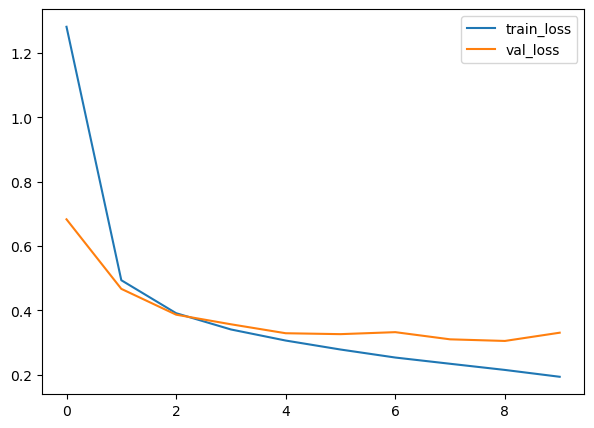

In [17]:
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [18]:
vgg_mini.evaluate(test_ds)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.3304


0.33038991689682007

Manual training loop of VGG11 

In [11]:
vgg_mini = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)))

In [15]:
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = vgg_mini(images, training=True)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, vgg_mini.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vgg_mini.trainable_variables))
    accuracy = train_accuracy(labels, predictions)
    return loss, accuracy

In [17]:
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    total_loss = 0.0
    total_acc = 0.0
    num_batches = 0
    for step,  (x_batch_train, y_batch_train) in enumerate(train_ds):
        step = train_step(x_batch_train, y_batch_train)
        total_loss += step[0].numpy()
        total_acc += step[1].numpy()
        num_batches += 1

    avg_loss = total_loss / num_batches
    avg_acc = total_acc / num_batches
    print(f"  Training Loss: {avg_loss:.4f}")
    print(f"  Training Accuracy: {avg_acc:.4f}")

Epoch 1/10


2025-10-18 15:17:28.994236: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  Training Loss: 0.8174
  Training Accuracy: 0.5345
Epoch 2/10


2025-10-18 15:18:30.779642: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  Training Loss: 0.4055
  Training Accuracy: 0.7468
Epoch 3/10
  Training Loss: 0.3347
  Training Accuracy: 0.7964
Epoch 4/10


2025-10-18 15:20:34.876069: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  Training Loss: 0.2933
  Training Accuracy: 0.8222
Epoch 5/10
  Training Loss: 0.2653
  Training Accuracy: 0.8394
Epoch 6/10
  Training Loss: 0.2413
  Training Accuracy: 0.8518
Epoch 7/10
  Training Loss: 0.2245
  Training Accuracy: 0.8616
Epoch 8/10


2025-10-18 15:24:42.452572: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  Training Loss: 0.2072
  Training Accuracy: 0.8695
Epoch 9/10
  Training Loss: 0.1931
  Training Accuracy: 0.8761
Epoch 10/10
  Training Loss: 0.1768
  Training Accuracy: 0.8820
